In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import datetime
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
%load_ext tensorboard

In [3]:
#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model.h5'
PATH_TO_MODELS = "Models/"

#dataset
CSV_PATH = "Datasets/completeDataset/"
CSV_NAME = "completeDataset.csv"
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

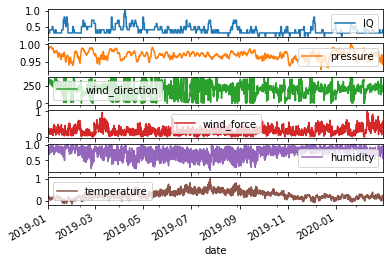

,IQ,pressure,wind_force,humidity,temperature,0,10,20,30,40,...,270,280,290,300,310,320,330,340,350,360
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,0.3,0.986479,0.152632,0.89,0.173913,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 03:00:00+00:00,0.3,0.985807,0.152632,0.85,0.173913,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2019-01-01 06:00:00+00:00,0.3,0.985040,0.152632,0.84,0.171498,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 09:00:00+00:00,0.3,0.985136,0.189474,0.84,0.178744,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 12:00:00+00:00,0.3,0.984273,0.300000,0.85,0.207729,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')
df['date'] = pd.to_datetime(df['date'],utc=True)

features = df[features_considered]
features.index = df['date']

dataset_test = features.values

def higher_value(features,i):
    return[row[i] for row in dataset_test]

max_pressure = max(higher_value(dataset_test,1))
max_wind_force = max(higher_value(dataset_test,3))
max_temperature = max(higher_value(dataset_test, 5))

#normalize
features['IQ'] = features['IQ'].apply(lambda x: x/10)
features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
features['humidity'] = features['humidity'].apply(lambda x: x/100)
features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

features.plot(subplots=True)
plt.show()

#wind_direction to categorical
features = pd.concat([features, pd.get_dummies(features['wind_direction'])], axis=1)
features = features.drop(columns=["wind_direction"])

features.head()

In [5]:
#Params
nb_prev_measures_for_predict = 16 # = N in the following explanation

In [6]:
x_train = []
y_train = []
countRow=0

for indexRow, rowx in features.iterrows():
    # for each day we found with a value at 12:00
    if indexRow.hour == 12 and countRow >= nb_prev_measures_for_predict:
        try:
            # indexes for x (the range is inversed as our data are from the oldest to the newest)
            batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
            # indexes for y
            batchY = [countRow,countRow+8,countRow+16]

            #application
            y_train.append(features.iloc[batchY]["IQ"].values)
            x_train.append(features.iloc[batchX].values)
        except:
            print("To long for ",indexRow),
    countRow+=1
    
x_train = np.array(x_train)
y_train = np.array(y_train)
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)

To long for  2020-02-28 12:00:00+00:00
To long for  2020-02-29 12:00:00+00:00
x_train : (421, 16, 42)
y_train : (421, 3)


In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [21]:
OPTIMIZER=tf.optimizers.RMSprop(learning_rate=0.005)
LOSS='mae'

if LOAD_MODEL:
    model = keras.models.load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(256,input_shape=input_shape,name='GRU_layer',go_backwards=True))
    model.add(tf.keras.layers.Dense(3,name="Dense_layer"))
    model.compile(optimizer=OPTIMIZER, loss=LOSS)
    model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU_layer (GRU)              (None, 256)               230400    
_________________________________________________________________
Dense_layer (Dense)          (None, 3)                 771       
Total params: 231,171
Trainable params: 231,171
Non-trainable params: 0
_________________________________________________________________


In [41]:
EPOCHS = 30
kfoldsize = 5

tensor_board = tf.keras.callbacks.TensorBoard('.\logs\\'+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))

for train_index,test_index in KFold(kfoldsize).split(x_train):
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    model.fit(x=x, y=y, validation_data=(x_val,y_val),epochs=EPOCHS,callbacks = [tensor_board])

Train on 336 samples, validate on 85 samples
Epoch 1/30
336/336 [==============================] - 0s 1ms/sample - loss: 0.0085 - val_loss: 0.0084
Epoch 2/30
336/336 [==============================] - 0s 940us/sample - loss: 0.0094 - val_loss: 0.0087
Epoch 3/30
336/336 [==============================] - 0s 890us/sample - loss: 0.0087 - val_loss: 0.0093
Epoch 4/30
336/336 [==============================] - 0s 973us/sample - loss: 0.0092 - val_loss: 0.0102
Epoch 5/30
336/336 [==============================] - 0s 904us/sample - loss: 0.0084 - val_loss: 0.0093
Epoch 6/30
336/336 [==============================] - 0s 946us/sample - loss: 0.0090 - val_loss: 0.0081
Epoch 7/30
336/336 [==============================] - 0s 1ms/sample - loss: 0.0092 - val_loss: 0.0105
Epoch 8/30
336/336 [==============================] - 0s 828us/sample - loss: 0.0085 - val_loss: 0.0105
Epoch 9/30
336/336 [==============================] - 0s 1ms/sample - loss: 0.0091 - val_loss: 0.0083
Epoch 10/30
336/336 [====

337/337 [==============================] - 1s 2ms/sample - loss: 0.0089 - val_loss: 0.0103
Epoch 20/30
337/337 [==============================] - 1s 2ms/sample - loss: 0.0087 - val_loss: 0.0149
Epoch 21/30
337/337 [==============================] - 0s 1ms/sample - loss: 0.0089 - val_loss: 0.0079
Epoch 22/30
337/337 [==============================] - 0s 1ms/sample - loss: 0.0083 - val_loss: 0.0068
Epoch 23/30
337/337 [==============================] - 0s 1ms/sample - loss: 0.0087 - val_loss: 0.0079
Epoch 24/30
337/337 [==============================] - 0s 1ms/sample - loss: 0.0084 - val_loss: 0.0086
Epoch 25/30
337/337 [==============================] - 0s 1ms/sample - loss: 0.0088 - val_loss: 0.0092
Epoch 26/30
337/337 [==============================] - 0s 1ms/sample - loss: 0.0095 - val_loss: 0.0114
Epoch 27/30
337/337 [==============================] - 0s 1ms/sample - loss: 0.0087 - val_loss: 0.0083
Epoch 28/30
337/337 [==============================] - 0s 1ms/sample - loss: 0.0087 -

In [42]:
def calc_accuracy_3days(y_pred,y_true):
    """
    calculate the accurracy of the prediction according to the true value for each day [D+1, D+2, D+3]
    """
    accuracy = [0,0,0]
    for pred,true in zip (y_pred,y_true):
        for plusDay in range(3):
            if int(true[plusDay]*10)- int(round(pred[plusDay],1)*10) == 0:
                accuracy[plusDay]+=1
    return(np.array(accuracy)/len(y_true)*100)

def mean_error_3days(y_pred,y_true):
    """
    calculate the mean error between the prediction and the true value for each day [D+1, D+2, D+3]
    """
    error = [0,0,0]
    for pred,true in zip (y_pred,y_true):
        for plusDay in range(3):
            error[plusDay] += abs(true[plusDay] - pred[plusDay])
    return(np.array(error)/len(y_true))

In [43]:
y_pred = model.predict(x_train)
accuracy = calc_accuracy_3days(y_pred,y_train)
meanError = mean_error_3days(y_pred,y_train)

Prediction of the air index quality (on training data)


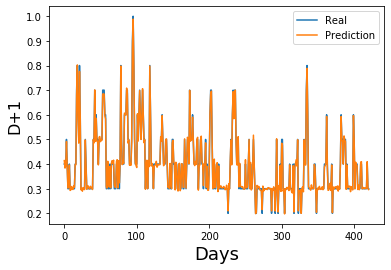

Accuracy with training data: 95.96 %
Mean error with training data: 0.01


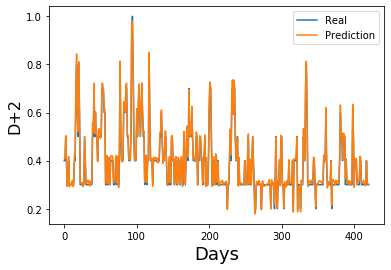

Accuracy with training data: 95.49 %
Mean error with training data: 0.01


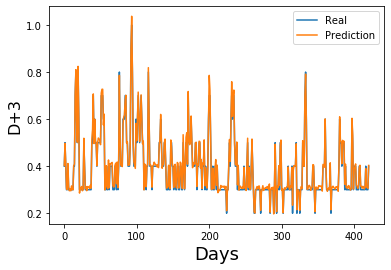

Accuracy with training data: 95.72 %
Mean error with training data: 0.01


In [44]:
print('Prediction of the air index quality (on training data)')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_train[:,plusDay], label='Real')
    plt.plot(y_pred[:,plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()

    print("Accuracy with training data:",round(accuracy[plusDay],2),"%")
    print("Mean error with training data:",round(meanError[plusDay],2))